**Решение задачи детекции людей на примере модели YOLO 11 nano**

Используемый датасет: [Human Detection Dataset](https://www.kaggle.com/datasets/constantinwerner/human-detection-dataset/data)

У используемого датасета нет аннотаций. Без меток (bounding boxes) мы не можем обучать YOLO "с нуля" на этом датасете. Нужен хотя бы один из вариантов: ручная или псевдоразметка. Заниматься ручной разметкой очень долго, поэтому прибегнем ко второй стратегии:

- Возьмем уже готовую модель (например, YOLOv8n, предобученную на COCO), пропустим наши изображения через неё и автоматически соберем разметку.
- Потом будет использовать эти псевдоразметки как обучающие метки для дообучения модели.

**Что мы сделаем:**

1) Установим Ultralytics (если ещё не установлен) для работы с YOLOv8.

2) Прогоним все изображения через предобученную модель YOLOv8n (на COCO), чтобы получить боксы людей (`class_id == 0` в COCO — это "person").

**Сохраним разметку в формате YOLO:**

- Формат строки: `class` `x_center` `y_center` `width` `height` (все координаты нормализованные от 0 до 1).

- Подготовим структуру папок для обучения (images/train, labels/train).

- После чего мы уже сможем дообучить свою модель на этих псевдоразмеченных данных

In [ ]:
!pip install ultralytics opencv-python tqdm

In [ ]:
import os
import cv2
from tqdm import tqdm
from ultralytics import YOLO
import shutil
import yaml
import random
import numpy as np
import torch
import matplotlib.pyplot as plt

In [ ]:
# Путь к распакованным изображениям
images_dir = '/content/drive/MyDrive/Colab Notebooks/DL Practice (AITH, spring 2025)/human detection dataset/1'
output_labels_dir = '/content/drive/MyDrive/Colab Notebooks/DL Practice (AITH, spring 2025)/archive_labels'  # куда будем сохранять разметку

In [ ]:
os.makedirs(output_labels_dir, exist_ok=True)

**Для разметки возьмем крошечную модель yolo8n**

In [ ]:
# Загружаем предобученную модель YOLOv8n
model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 72.6MB/s]


In [ ]:
# Проходим по всем изображениям
for img_name in tqdm(os.listdir(images_dir)):
    img_path = os.path.join(images_dir, img_name)
    if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    # Прогоняем через модель
    results = model.predict(img_path, conf=0.3, classes=[0], verbose=False)  # только класс 0, то есть "person"
    boxes = results[0].boxes

    if boxes is None or len(boxes) == 0:
        continue  # если ничего не нашло — пропускаем

    # Загружаем изображение для получения размеров
    img = cv2.imread(img_path)
    height, width, _ = img.shape

    # Записываем результаты
    label_lines = []
    for box in boxes:
        xyxy = box.xyxy[0].cpu().numpy()
        x_min, y_min, x_max, y_max = xyxy

        # Конвертация в YOLO-формат
        x_center = (x_min + x_max) / 2 / width
        y_center = (y_min + y_max) / 2 / height
        bbox_width = (x_max - x_min) / width
        bbox_height = (y_max - y_min) / height

        label_lines.append(f"0 {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}")

    # Сохраняем файл с разметкой
    label_filename = os.path.splitext(img_name)[0] + ".txt"
    label_path = os.path.join(output_labels_dir, label_filename)
    with open(label_path, 'w') as f:
        f.write("\n".join(label_lines))

100%|██████████| 559/559 [03:15<00:00,  2.85it/s]


Отлично! Теперь у нас есть псевдоразметка, теперь мы можем плавно переходить к обучению. Для начала создадим `data.yaml` файл для тренировки

In [ ]:
# Пути к исходным папкам
images_src_dir = '/content/drive/MyDrive/Colab Notebooks/DL Practice (AITH, spring 2025)/human detection dataset/1'  # изображения
labels_src_dir = '/content/drive/MyDrive/Colab Notebooks/DL Practice (AITH, spring 2025)/archive_labels'  # сгенерированные разметки

In [ ]:
# Куда будем копировать
dataset_base_dir = '/content/drive/MyDrive/Colab Notebooks/DL Practice (AITH, spring 2025)/training_data'
splits = ['train', 'val', 'test']

# Создаем папки
for split in splits:
    os.makedirs(os.path.join(dataset_base_dir, f'images/{split}'), exist_ok=True)
    os.makedirs(os.path.join(dataset_base_dir, f'labels/{split}'), exist_ok=True)

In [ ]:
# Получаем список всех картинок
image_filenames = [f for f in os.listdir(images_src_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

In [ ]:
# Перемешиваем и делим
random.seed(42)  # чтобы деление было воспроизводимым
random.shuffle(image_filenames)

n_total = len(image_filenames)
n_train = int(n_total * 0.8)
n_val = int(n_total * 0.1)
n_test = n_total - n_train - n_val

train_files = image_filenames[:n_train]
val_files = image_filenames[n_train:n_train+n_val]
test_files = image_filenames[n_train+n_val:]

split_dict = {
    'train': train_files,
    'val': val_files,
    'test': test_files
}

In [ ]:
# Копируем изображения и разметки в соответствующие папки
for split, files in split_dict.items():
    for img_name in files:
        # Копируем изображение
        src_img_path = os.path.join(images_src_dir, img_name)
        dst_img_path = os.path.join(dataset_base_dir, f'images/{split}', img_name)
        shutil.copy2(src_img_path, dst_img_path)

        # Копируем разметку (если есть)
        label_name = os.path.splitext(img_name)[0] + '.txt'
        src_label_path = os.path.join(labels_src_dir, label_name)
        dst_label_path = os.path.join(dataset_base_dir, f'labels/{split}', label_name)
        if os.path.exists(src_label_path):
            shutil.copy2(src_label_path, dst_label_path)

print("Файлы успешно распределены по train/val/test!")

Файлы успешно распределены по train/val/test!


In [ ]:
# Создаем data.yaml
data_yaml = {
    'path': dataset_base_dir,
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'names': {0: 'person'}
}

yaml_path = os.path.join(dataset_base_dir, 'data.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f)

print(f"Файл data.yaml создан: {yaml_path}")
print(f"Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")

Файл data.yaml создан: /content/drive/MyDrive/Colab Notebooks/DL Practice (AITH, spring 2025)/training_data/data.yaml
Train: 447, Val: 55, Test: 57


In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
1
Tesla T4


In [ ]:
# Загружаем предобученную модель
model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 137MB/s]


In [ ]:
# Запускаем обучение
model.train(
    data='/content/drive/MyDrive/Colab Notebooks/DL Practice (AITH, spring 2025)/training_data/data.yaml',  # Путь к YAML-файлу
    epochs=50,                           # Количество эпох
    imgsz=640,                           # Размер картинок
    batch=8,                             # Размер батча
    device=0,                            # GPU device
    workers=2,                           # Количество воркеров для загрузки данных
    save=True,                           # Сохранять чекпоинты
    save_period=10,                      # Сохранять модель каждые 10 эпох
    verbose=True                         # Показывать лог обучения
)

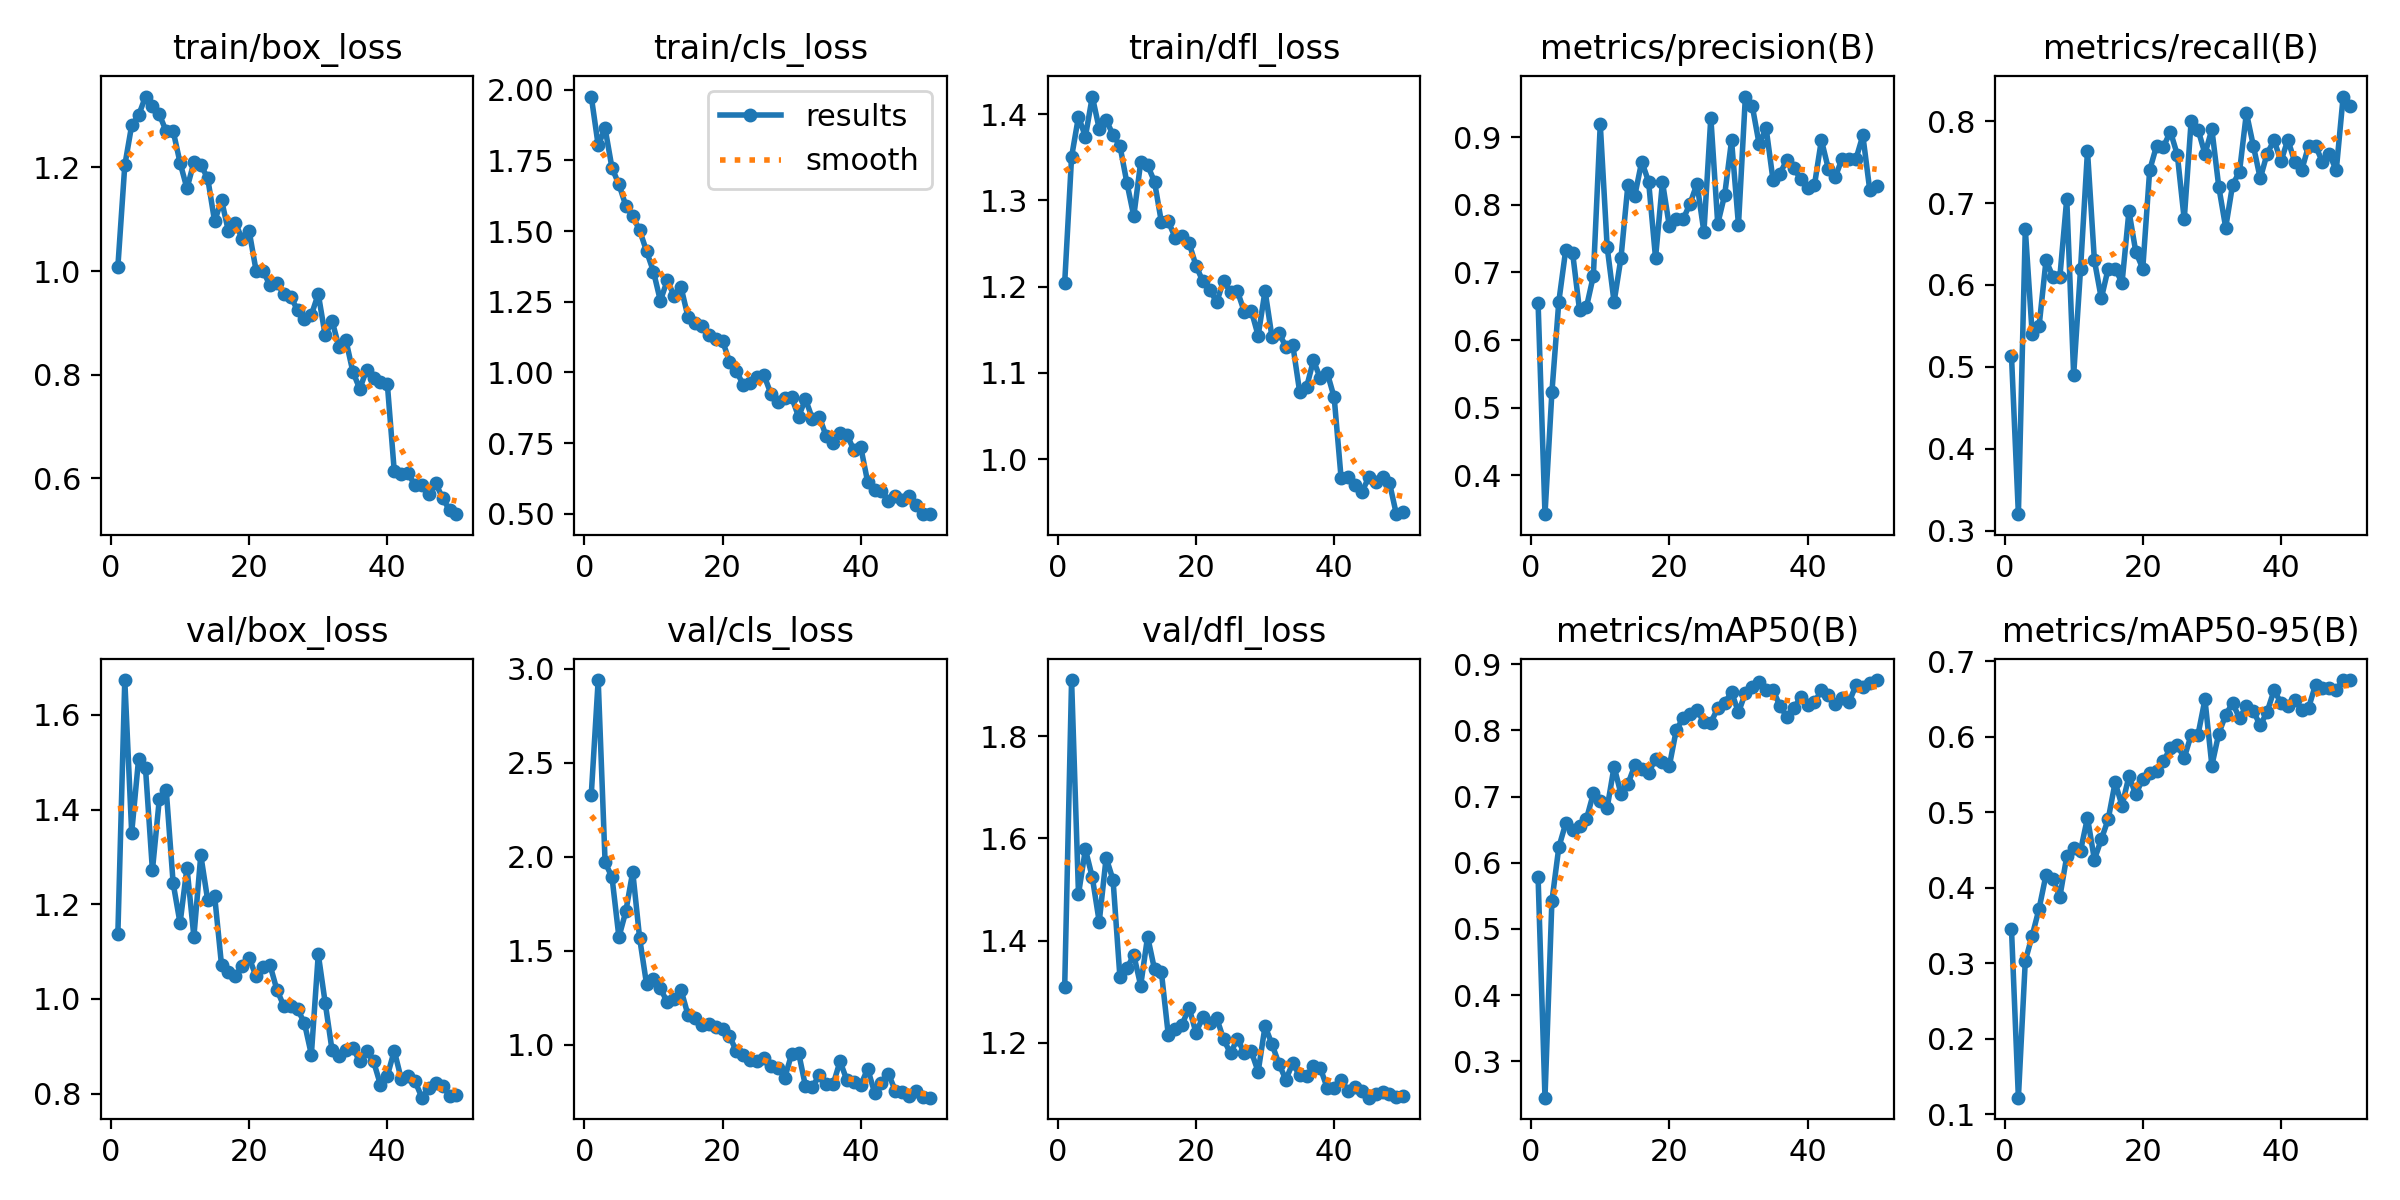

In [ ]:
from IPython.display import Image, display

# Путь до папки, куда Ultralytics сохранил графики
training_run_dir = '/content/runs/detect/train'

# Посмотрим графики
display(Image(filename=os.path.join(training_run_dir, 'results.png')))

In [ ]:
# Загружаем лучшую модель
model = YOLO('/content/runs/detect/train/weights/best.pt')

# Валидируем модель
metrics = model.val(
    data='/content/drive/MyDrive/Colab Notebooks/DL Practice (AITH, spring 2025)/training_data/data.yaml',
    imgsz=640,
    batch=8,
    split='test',
    device='auto'
)

In [ ]:
def print_metrics(metrics):
    print("\n📊 Результаты на тестовой выборке:\n")
    print(f"mAP 0.5:   {metrics.box.map50:.4f} (средняя точность при IoU=0.5)")
    print(f"mAP 0.5:0.95: {metrics.box.map:.4f} (средняя точность при разных IoU от 0.5 до 0.95)\n")
    print(f"Detection Speed: {metrics.speed['inference']:.2f} ms per image (время инференса)\n")

    if hasattr(metrics, 'confusion_matrix'):
        cm = metrics.confusion_matrix
        precision = cm.matrix[1,1] / (cm.matrix[1,1] + cm.matrix[0,1] + 1e-6)
        recall = cm.matrix[1,1] / (cm.matrix[1,1] + cm.matrix[1,0] + 1e-6)
        print(f"Precision (calculated): {precision:.4f}")
        print(f"Recall (calculated):    {recall:.4f}")

print_metrics(metrics)


📊 Результаты на тестовой выборке:

mAP 0.5:   0.8738 (средняя точность при IoU=0.5)
mAP 0.5:0.95: 0.6950 (средняя точность при разных IoU от 0.5 до 0.95)

Detection Speed: 6.85 ms per image (время инференса)

Precision (calculated): 0.0000
Recall (calculated):    0.0000


Получились почему-то нулевые значения Precision и Recall, хотя другие две метрики вышли довольно хорошими. Разметка была проверена, она в целом адекватная. Попробуем посмотреть, как наша модель рисует bounding box


image 1/1 /content/7.png: 576x640 1 person, 41.2ms
Speed: 3.9ms preprocess, 41.2ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 640)


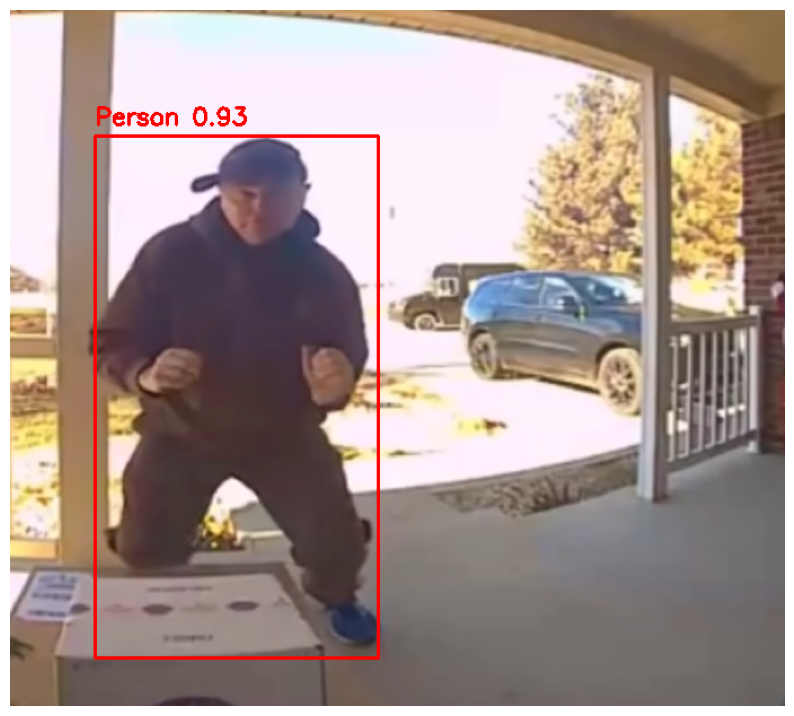

In [ ]:
# Путь к картинке
image_path = '7.png'

# Прогоняем инференс
results = model.predict(source=image_path, imgsz=640, conf=0.25, device=0)

# Получаем результаты
result = results[0]

# Загружаем картинку
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Рисуем боксы
for box in result.boxes:
    xyxy = box.xyxy[0].cpu().numpy()  # [x1, y1, x2, y2]
    conf = box.conf[0].cpu().numpy()
    cls = int(box.cls[0].cpu().numpy())

    # Рисуем прямоугольник
    x1, y1, x2, y2 = map(int, xyxy)
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    label = f"Person {conf:.2f}"
    cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

# Показываем картинку
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

Модель отлично определяет людей на фото и хорошо рисует bbox. Проблема оказалось в самом устройстве библиотеке ultralytics и том, как она работает с метриками. Я сделал ручной подсчет Precision и Recall, поэтому теперь они выглядят адекватно

In [ ]:
# Параметры
conf_threshold = 0.5
iou_threshold = 0.5     # стандартный порог IoU для зачета попадания
image_dir = '/content/drive/MyDrive/Colab Notebooks/DL Practice (AITH, spring 2025)/training_data/images/test'
label_dir = '/content/drive/MyDrive/Colab Notebooks/DL Practice (AITH, spring 2025)/training_data/labels/test'
model_path = '/content/runs/detect/train/weights/best.pt'

# Загружаем модель
model = YOLO(model_path)

# Функция для расчёта IoU
def calculate_iou(box1, box2):
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area
    iou = inter_area / union_area if union_area != 0 else 0
    return iou

# Счетчики
total_tp = 0
total_fp = 0
total_fn = 0

# Проходим по всем тестовым изображениям
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

for img_name in tqdm(image_files, desc="Evaluating"):
    img_path = os.path.join(image_dir, img_name)
    label_path_file = os.path.join(label_dir, os.path.splitext(img_name)[0] + '.txt')

    # Загружаем изображение
    img = cv2.imread(img_path)
    height, width = img.shape[:2]

    # Загружаем реальную разметку
    gt_boxes = []
    if os.path.exists(label_path_file):
        with open(label_path_file, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) == 5:
                    _, x_center, y_center, bbox_width, bbox_height = map(float, parts)
                    # Преобразуем в формат (x1, y1, x2, y2)
                    x_center *= width
                    y_center *= height
                    bbox_width *= width
                    bbox_height *= height
                    x1 = x_center - bbox_width/2
                    y1 = y_center - bbox_height/2
                    x2 = x_center + bbox_width/2
                    y2 = y_center + bbox_height/2
                    gt_boxes.append([x1, y1, x2, y2])

    # Прогоняем инференс модели
    results = model.predict(source=img_path, imgsz=640, conf=conf_threshold, device='auto', verbose=False)
    preds = results[0].boxes

    # Получаем предсказанные боксы
    pred_boxes = []
    if preds is not None and preds.xyxy is not None:
        for box, conf, cls in zip(preds.xyxy, preds.conf, preds.cls):
            if conf > conf_threshold:
                pred_boxes.append(box.cpu().numpy())

    # Сопоставление предсказаний и реальных боксов
    matched_gt = set()
    matched_pred = set()

    for i, pred in enumerate(pred_boxes):
        for j, gt in enumerate(gt_boxes):
            iou = calculate_iou(pred, gt)
            if iou >= iou_threshold and j not in matched_gt:
                matched_pred.add(i)
                matched_gt.add(j)
                break

    tp = len(matched_pred)
    fp = len(pred_boxes) - tp
    fn = len(gt_boxes) - tp

    total_tp += tp
    total_fp += fp
    total_fn += fn

# Рассчитываем финальные метрики
precision = total_tp / (total_tp + total_fp + 1e-6)
recall = total_tp / (total_tp + total_fn + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)

# Вывод результатов
print("\n📊 Финальные метрики на тестовом наборе:")
print(f"True Positives (TP): {total_tp}")
print(f"False Positives (FP): {total_fp}")
print(f"False Negatives (FN): {total_fn}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

Evaluating: 100%|██████████| 57/57 [00:03<00:00, 17.99it/s]


📊 Финальные метрики на тестовом наборе:
True Positives (TP): 87
False Positives (FP): 14
False Negatives (FN): 21
Precision: 0.8614
Recall:    0.8056
F1-Score:  0.8325


Что ж, получились довольно неплохие результаты, учитывая что мы:
- не использовали аугментацию данных (хотя у нас довольно крошечный датасет)
- у нас не было разметки, поэтому мы сделали её автоматически через маленькую модельку (не лучшее качество)
- для дообучения также использовали не топовую модель (можем получить лучший результат)

**Вывод - перечисленные выше пункты нужно учесть в следующем пайплайне**

In [ ]:
shutil.make_archive('/content/runs_yolo-11n_backup', 'zip', '/content/runs')